# Read this section importantly!

In [1]:
!nvidia-smi

Sun Apr 23 16:30:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Install some required libraries
# Feel free to add more if you want
!pip install -q python-levenshtein torchsummaryX

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 24.2 MB/s eta 0:00:00


In [3]:
pip install transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 10.2 MB/s eta 0:00:00


In [4]:
import torch
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchsummaryX import summary
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import torchvision.transforms as tvt
import torchaudio.transforms as tat
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import gc

import zipfile
import pandas as pd
from tqdm import tqdm
import os
import datetime

import warnings
warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", DEVICE)

Device:  cuda
Device:  cuda


# Dataset and Dataloaders

In terms of the dataset, the dataset structure for HW3P2 and HW4P2 dataset are very similar. Can you spot out the differences? What all will be required?? 

Hints:

- Check how big is the dataset (do you require memory efficient loading techniques??)
- How do we load mfccs? Do we need to normalise them? 
- Does the data have \<SOS> and \<EOS> tokens in each sequences? Do we remove them or do we not remove them? (Read writeup)
- Would we want a collating function? Ask yourself: Why did we need a collate function last time?
- Observe the VOCAB, is the dataset same as HW3P2? 
- Should you add augmentations, if yes which augmentations? When should you add augmentations? (Check bootcamp for answer)


In [6]:
def technical_indicators(df):
  df_close=df['Close']
  df_close=pd.DataFrame(df_close, columns=['Close'])
  df11=df_close.reset_index()
  #RSI
  df11['change'] = df11['Close'].diff()
  df['change']=df11['change']
  df['delta']=(df['change']>0)*1.
  def rma(x, n):
      """Running moving average"""
      a = np.full_like(x, np.nan)
      a[n] = x[1:n+1].mean()
      for i in range(n+1, len(x)):
          a[i] = (a[i-1] * (n - 1) + x[i]) / n
      return a

  #SMA  #10days
  df11['SMA30'] = df11['Close'].rolling(10).mean()

  df11.drop(columns=['Close','change','index'], inplace=True)
  df_cat=pd.concat([df, df11], axis=1)
  df_cat.fillna(method='bfill', axis=0, inplace=True)
  df_cat.fillna(method='ffill', axis=0, inplace=True)
  return df_cat
APPL_price = pd.read_csv("GOOGL.csv")
APPL=technical_indicators(APPL_price).drop(columns=['Date','Adj Close'])
print(APPL.columns)
APPL=APPL.reset_index()
APPL

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'change', 'delta', 'SMA30'], dtype='object')


,index,Open,High,Low,Close,Volume,change,delta,SMA30
0,0,53.060001,54.250000,52.854500,53.967999,54584000,-0.198498,0.0,52.671500
1,1,53.950500,54.099998,53.526001,53.769501,31126000,-0.198498,0.0,52.671500
2,2,53.451000,54.875500,53.451000,54.472500,39884000,0.702999,1.0,52.671500
3,3,54.213501,54.737499,53.605000,53.866001,42434000,-0.606499,0.0,52.671500
4,4,54.148998,54.400002,53.334000,53.690498,69590000,-0.175503,0.0,52.671500
...,...,...,...,...,...,...,...,...,...
1253,1253,106.980003,107.589996,105.120003,106.440002,27067400,-1.979996,0.0,103.791000
1254,1254,106.550003,106.730003,104.680000,105.349998,26311800,-1.090004,0.0,104.080000
1255,1255,106.580002,106.750000,104.339996,104.639999,24370300,-0.709999,0.0,104.441000
1256,1256,105.839996,107.489998,105.839996,107.430000,24843600,2.790001,1.0,105.045000


In [7]:
#Normalize time series
scaler = StandardScaler()
dataset_standard = scaler.fit_transform(APPL)
dataset=dataset_standard
dataset_standard

array([[-1.73067453, -1.17042469, -1.15296776, ..., -0.13259901,
        -1.04721854, -1.18043735],
       [-1.72792087, -1.14067114, -1.15793104, ..., -0.13259901,
        -1.04721854, -1.18043735],
       [-1.72516721, -1.15736054, -1.13227119, ...,  0.36139377,
         0.95491052, -1.18043735],
       ...,
       [ 1.72516721,  0.61779749,  0.58415497, ..., -0.41288591,
        -1.04721854,  0.55264834],
       [ 1.72792087,  0.59307225,  0.60864006, ...,  1.50500702,
         0.95491052,  0.57286843],
       [ 1.73067453,  0.62815518,  0.65661787, ...,  0.76524941,
         0.95491052,  0.59958306]])

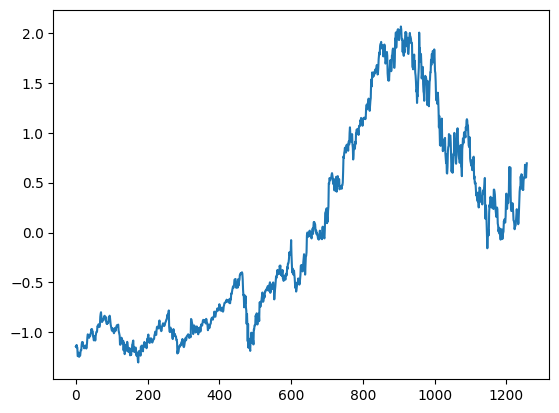

In [8]:
plt.plot(dataset_standard[:,4]) #plot closing price

In [9]:
#TODO: try to tune this
config = {
  'batch_size': 64,
  'lr':1e-4,
  'epochs': 30,
}

In [10]:
class TransformerDataset(Dataset):
    def __init__(self, data, indices, enc_seq_len, pred_seq_len) :
        super().__init__()
        self.data = data
        self.indices = indices
        self.enc_seq_len = enc_seq_len
        self.pred_seq_len = pred_seq_len

    def __len__(self):
        return len(self.indices)

    def get_src_tgt(self, sequence, encoder_seq_len, pred_seq_len) :
                          #65 days     60 days,      5 days
        # encoder input
        window_len=len(sequence)
        src = sequence[:encoder_seq_len]      #0~59 inclusive
        
        tgt = sequence[encoder_seq_len-1:window_len-1]     #59~63 inclusive

        true = sequence[-pred_seq_len:]     #60~64 inclusive

        return src, tgt, true

    def __getitem__(self, index):
        start, end = self.indices[index]
        sequence = self.data[start:end]
        src, tgt, true = self.get_src_tgt(sequence, self.enc_seq_len, self.pred_seq_len)

        return src, tgt, true
    

In [11]:
def get_windows(data, window_size, step_size):
    # Start the first sub-sequence at index position 0
    start = 0
    end = window_size
    
    indices = []
    while end <= len(data)-1:      #proceed window by step size, count how many sequences 
        indices.append((start, end))
        start += step_size
        end += step_size
    return indices

In [12]:
dataset=dataset.tolist()*1  #TODO: try to Tune, to repeat stock price make longer dataset
len(dataset)
a=int(0.7*len(dataset))
X_train=dataset[0:a]
X_test=dataset[a:]
print(len(X_train))
len(X_test)


880


378

In [ ]:
# plt.plot(np.array(X_train)[:,4])

torch.Size([128, 60, 9]) torch.Size([128, 10, 9])
x:  tensor([-1.1498, -1.1375, -1.1326, -1.1321, -1.1323, -1.1319, -1.1281, -1.1255,
        -1.1224, -1.1205, -1.1144, -1.1111, -1.1054, -1.0932, -1.0867, -1.0831,
        -1.0829, -1.0792, -1.0696, -1.0644, -1.0639, -1.0637, -1.0662, -1.0714,
        -1.0746, -1.0728, -1.0703, -1.0670, -1.0677, -1.0681, -1.0649, -1.0592,
        -1.0521, -1.0446, -1.0368, -1.0312, -1.0209, -1.0083, -0.9955, -0.9845,
        -0.9775, -0.9716, -0.9660, -0.9557, -0.9415, -0.9318, -0.9288, -0.9300,
        -0.9335, -0.9369, -0.9392, -0.9374, -0.9369, -0.9395, -0.9423, -0.9417,
        -0.9399, -0.9377, -0.9330, -0.9267])
tgt:  tensor([-0.9267, -0.9190, -0.9144, -0.9100, -0.9051, -0.9014, -0.8943, -0.8839,
        -0.8743, -0.8641])
y_train:  tensor([-0.9190, -0.9144, -0.9100, -0.9051, -0.9014, -0.8943, -0.8839, -0.8743,
        -0.8641, -0.8528])


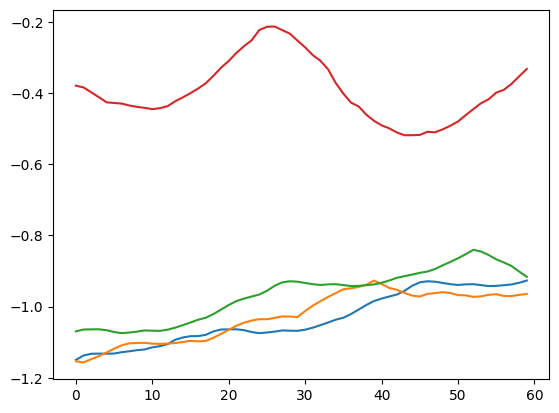

In [13]:
# Dataset Dataloader:
#TODO: tune context_len and pred_len
context_len=60
pred_len=10
window_size=context_len+pred_len
training_indices = get_windows(X_train, window_size, step_size=3) #TODO: Tune step size... 
val_indices = get_windows(X_test, window_size, step_size=1) #TODO: Tune step size... 
test_indices = get_windows(dataset, window_size, step_size=1) 

# print(training_indices)
train_data=TransformerDataset(torch.FloatTensor(X_train), training_indices, context_len, pred_len) 
val_data=TransformerDataset(torch.FloatTensor(X_test), val_indices, context_len, pred_len) 
test_data=TransformerDataset(torch.FloatTensor(dataset), test_indices, context_len, pred_len) 

train_loader = torch.utils.data.DataLoader(
    dataset     = train_data, 
    batch_size  = 128,
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    dataset     = val_data, 
    batch_size  = 24,
    drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    dataset     = test_data, 
    batch_size  = 1,
    pin_memory  = False
)

for batch in train_loader: 
    src, tgt, y_train=batch
    print(src.shape, tgt.shape)
    print("x: ", src[0,:,-1])   #60 days context  
    print("tgt: ", tgt[0,:,-1]) #should be next five days 
    print("y_train: ", y_train[0,:,-1])  #True label should shift by one to right
    plt.plot(src[0,:,-1])
    plt.plot(src[1,:,-1])
    plt.plot(src[2,:,-1])
    plt.plot(src[3,:,-1]) #should shift by step size in graph below
    break

In [14]:
class PositionalEncoder(nn.Module):
    def __init__(self, dropout= 0.1, max_seq_len = 5000, d_model = 512):

        super().__init__()
        self.d_model = d_model
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_seq_len).unsqueeze(1)
        exp_input = torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model) 
        div_term = torch.exp(exp_input) # Returns a new tensor with the exponential of the elements of exp_input
        pe = torch.zeros(max_seq_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term) # torch.Size([target_seq_len, dim_val])
        pe = pe.unsqueeze(0).transpose(0, 1) # torch.Size([target_seq_len, input_size, dim_val])
        # register that pe is not a model parameter
        self.register_buffer('pe', pe)
        
    def forward(self, x) :
        add = self.pe[:x.size(1), :].squeeze(1)
        x = x + add
        return self.dropout(x)


In [15]:
class Transformer(nn.Module):
    def __init__(self, input_dim, output_dim, d_model=512, nhead=8, num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=2048, dropout=0.1,encode_seq_len=60,pred_seq_len=10):
        super(Transformer, self).__init__()
        self.nhead=nhead
        self.d_model=d_model
        self.encode_seq_len=encode_seq_len
        self.embedding = nn.Linear(input_dim, d_model) 
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        self.pred_seq_len=pred_seq_len
        self.linear_out = nn.Linear(d_model*pred_seq_len, pred_seq_len)
        self.positional_encoding_layer = PositionalEncoder(dropout, encode_seq_len, d_model )


    # def positional_encoding(self, max_seq_length=context_len, hidden_size=512):
    #     # Create empty matrix
    #     position = torch.arange(max_seq_length).unsqueeze(1).to(device)
    #     div_term = torch.exp(torch.arange(0, hidden_size, 2) * -(torch.log(torch.tensor(10000.0)) / hidden_size)).to(device)
    #     pe = torch.zeros(max_seq_length, hidden_size).to(device)
    #     # Compute the positional encoding values
    #     pe[:, 0::2] = torch.sin(position * div_term)
    #     pe[:, 1::2] = torch.cos(position * div_term)
    #     pe = pe.unsqueeze(0)
    #     return pe
        
    def forward(self, x, query, src_mask=None, tgt_mask=None):
        # print("in,",x.shape) #32 10 29, batch len feature
        batch_size, seq_len, feature=x.shape

        # # print("x",x.shape)
        # pos_encodings = self.positional_encoding(self.encode_seq_len, self.d_model)
        # pos_encodings_query = self.positional_encoding(1, self.d_model)
        

        # #encode x
        x = self.embedding(x) 
        x = self.positional_encoding_layer(x)

        #encode query
        query=self.embedding(query) 

        encoder_out = self.encoder(x)
        decoder_out = self.decoder(query, encoder_out,tgt_mask=tgt_mask, memory_mask=src_mask )
        # print("asdasdasdasdasd",decoder_out.shape)

        decoder_out = self.linear_out(decoder_out.flatten(start_dim=1))
        
        return decoder_out


In [16]:
gc.collect()
torch.cuda.empty_cache()

In [17]:
#TODO: tune model parameters
model=Transformer(input_dim=9, output_dim=1, d_model=512, nhead=4, 
                  num_encoder_layers=4, num_decoder_layers=4, dim_feedforward=512, 
                  dropout=0.1, encode_seq_len=context_len, pred_seq_len=pred_len).to(device)
# print(x.size)
for x, y,z in train_loader: 
    x=torch.FloatTensor(x).to(device)
    y=torch.FloatTensor(y).to(device)
    print("x shape:", x.shape, "y shape:", y.shape)
    print("out shape", model(x,y).shape)
    # summary(model, x1)
    break
print("context len",model.encode_seq_len,"pred_len", model.pred_seq_len)

x shape: torch.Size([128, 60, 9]) y shape: torch.Size([128, 10, 9])
out shape torch.Size([128, 10])
context len 60 pred_len 10


# Model Setup 

# Loss Function, Optimizers, Scheduler

In [18]:
optimizer   = torch.optim.Adam(model.parameters(), lr= config['lr'])
criterion   = torch.nn.MSELoss() 
scaler      = torch.cuda.amp.GradScaler()

# Optional (but Recommended): Create a custom class for a Teacher Force Schedule

In [19]:
def generate_square_subsequent_mask(dim1: int, dim2: int, dim3: int): 
    return torch.triu(torch.ones(dim1, dim2, dim3) * float('-inf'), diagonal=1)

# Train and Validation functions 


In [20]:
class Trainer():
  def __init__(self, model, loader, optimizer, criterion, scheduler, teacher_forcing_ratio, val_loader):
    self.model      = model
    self.loader     = loader
    self.optimizer  = optimizer
    self.criterion  = criterion
    self.train_plot=[]
    self.teacher_forcing_ratio=teacher_forcing_ratio
    self.teacher=True
    self.val_loader=val_loader
    
  def train(self):
      self.model.train() # set to training mode
      self.model.to(device)

      batch_bar = tqdm(total=len(self.loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
      running_loss        = 0.0

      for i, batch in enumerate(self.loader):
          self.optimizer.zero_grad()

          src, trg, y_train = batch

          src = src.to(device)
          trg = trg.to(device)
          y_train = y_train.to(device)

          batch_size = src.shape[0]

          src_mask = generate_square_subsequent_mask( dim1=batch_size*self.model.nhead,dim2=pred_len,dim3=context_len).to(device)
          tgt_mask = generate_square_subsequent_mask( dim1=batch_size*self.model.nhead,dim2=pred_len,dim3=pred_len).to(device)

          y_pred = self.model(src, trg, src_mask=src_mask, tgt_mask=tgt_mask)

          #0,'Time',1,'Open',2,'High',3,'Low',4,'Close',5,'Volume',6,'change',7,'delta',8,'Moving Average'
          pred_what=4
          loss = criterion(y_pred, y_train[:,:,pred_what])    #TODO: try changing 8 to others, if want the model to learn other columns
          loss.backward()
          optimizer.step()
          
          self.train_plot.append(loss.item())
          running_loss += loss.item()
          
          batch_bar.set_postfix(
              loss="{:.04f}".format(running_loss/(i+1)),
              lr="{:.04f}".format(float(self.optimizer.param_groups[0]['lr'])),
              # teacher_time="{:.04f}".format(teach/10)
               )
          batch_bar.update()

          del src, trg, y_train
          torch.cuda.empty_cache()

      batch_bar.close()

      return running_loss/len(self.loader)

  def validate(self):
      self.model.eval() # set to training mode
      self.model.to(device)

      batch_bar = tqdm(total=len(self.loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
      running_loss        = 0.0

      for i, batch in enumerate(self.val_loader):
          self.optimizer.zero_grad()

          src, trg, y_test = batch

          src = src.to(device)
          trg = trg.to(device)
          y_test = y_test.to(device)

          batch_size = src.shape[0]

          src_mask = generate_square_subsequent_mask( dim1=batch_size*self.model.nhead,dim2=pred_len,dim3=context_len).to(device)
          tgt_mask = generate_square_subsequent_mask( dim1=batch_size*self.model.nhead,dim2=pred_len,dim3=pred_len).to(device)

          y_pred = self.model(src, trg, src_mask=src_mask, tgt_mask=tgt_mask)

          #0,'Time',1,'Open',2,'High',3,'Low',4,'Close',5,'Volume',6,'change',7,'delta',8,'Moving Average'
          pred_what=4
          # print(y_pred[:,1].shape,y_test[:,1,pred_what].shape)
          val_loss = criterion(y_pred[:,0], y_test[:,0,pred_what])    #TODO: try changing 8 to others, if want the model to learn other columns

          running_loss += val_loss.item()
          
          batch_bar.set_postfix(
              loss="{:.04f}".format(running_loss/(i+1))
               )
          batch_bar.update()

          del src, trg, y_test
          torch.cuda.empty_cache()

      batch_bar.close()

      return running_loss/len(self.loader)

  def test(self, test_loader):
        self.model.eval() # set to training mode
        self.model.to(device)
        batch_bar = tqdm(total=len(test_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
        prediction=[]
        for i, batch in enumerate(test_loader):
            self.optimizer.zero_grad()

            src, trg, y_test = batch

            src = src.to(device)
            trg = trg.to(device)

            batch_size = src.shape[0]

            src_mask = generate_square_subsequent_mask( dim1=batch_size*self.model.nhead,dim2=pred_len,dim3=context_len).to(device)
            tgt_mask = generate_square_subsequent_mask( dim1=batch_size*self.model.nhead,dim2=pred_len,dim3=pred_len).to(device)

            y_pred = self.model(src, trg, src_mask=src_mask, tgt_mask=tgt_mask)[:,0]
            prediction.append(y_pred[0])

            #0,'Time',1,'Open',2,'High',3,'Low',4,'Close',5,'Volume',6,'change',7,'delta',8,'Moving Average'
            del src, trg, y_test
            torch.cuda.empty_cache()
            batch_bar.update()

        batch_bar.close()

        return prediction

In [21]:
gc.collect()
torch.cuda.empty_cache()

In [22]:
scheduler   = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.99)
trainer=Trainer(model, train_loader, optimizer, criterion,  scheduler, teacher_forcing_ratio=1.0, val_loader=val_loader)


Epoch: 1/300


	Train Loss 0.7926	 Learning Rate 0.0001000	 Validation Loss 2.5365

Epoch: 2/300


	Train Loss 0.2276	 Learning Rate 0.0000990	 Validation Loss 3.8998

Epoch: 3/300


	Train Loss 0.1303	 Learning Rate 0.0000980	 Validation Loss 0.5234

Epoch: 4/300


	Train Loss 0.1170	 Learning Rate 0.0000970	 Validation Loss 0.3155

Epoch: 5/300


	Train Loss 0.0876	 Learning Rate 0.0000961	 Validation Loss 1.3831

Epoch: 6/300


	Train Loss 0.0733	 Learning Rate 0.0000951	 Validation Loss 2.2639

Epoch: 7/300


	Train Loss 0.0591	 Learning Rate 0.0000941	 Validation Loss 1.4271

Epoch: 8/300


	Train Loss 0.0448	 Learning Rate 0.0000932	 Validation Loss 1.1443

Epoch: 9/300


	Train Loss 0.0473	 Learning Rate 0.0000923	 Validation Loss 1.6300

Epoch: 10/300


	Train Loss 0.0373	 Learning Rate 0.0000914	 Validation Loss 2.2382

Epoch: 11/300


	Train Loss 0.0409	 Learning Rate 0.0000904	 Validation Loss 1.2876

Epoch: 12/300


	Train Loss 0.0379	 Learning Rate 0.0000895	 Validation Loss 1.0380

Epoch: 13/300


	Train Loss 0.0347	 Learning Rate 0.0000886	 Validation Loss 1.3774

Epoch: 14/300


	Train Loss 0.0285	 Learning Rate 0.0000878	 Validation Loss 1.0802

Epoch: 15/300


	Train Loss 0.0329	 Learning Rate 0.0000869	 Validation Loss 1.6972

Epoch: 16/300


	Train Loss 0.0304	 Learning Rate 0.0000860	 Validation Loss 1.7768

Epoch: 17/300


	Train Loss 0.0380	 Learning Rate 0.0000851	 Validation Loss 1.3038

Epoch: 18/300


	Train Loss 0.0375	 Learning Rate 0.0000843	 Validation Loss 1.0613

Epoch: 19/300


	Train Loss 0.0321	 Learning Rate 0.0000835	 Validation Loss 1.2230

Epoch: 20/300


	Train Loss 0.0301	 Learning Rate 0.0000826	 Validation Loss 1.0205

Epoch: 21/300


	Train Loss 0.0288	 Learning Rate 0.0000818	 Validation Loss 0.5366

Epoch: 22/300


	Train Loss 0.0303	 Learning Rate 0.0000810	 Validation Loss 1.5938

Epoch: 23/300


	Train Loss 0.0277	 Learning Rate 0.0000802	 Validation Loss 1.8725

Epoch: 24/300


	Train Loss 0.0255	 Learning Rate 0.0000794	 Validation Loss 1.2447

Epoch: 25/300


	Train Loss 0.0262	 Learning Rate 0.0000786	 Validation Loss 1.0917

Epoch: 26/300


	Train Loss 0.0256	 Learning Rate 0.0000778	 Validation Loss 0.8267

Epoch: 27/300


	Train Loss 0.0274	 Learning Rate 0.0000770	 Validation Loss 0.9644

Epoch: 28/300


	Train Loss 0.0241	 Learning Rate 0.0000762	 Validation Loss 1.4474

Epoch: 29/300


	Train Loss 0.0270	 Learning Rate 0.0000755	 Validation Loss 1.2279

Epoch: 30/300


	Train Loss 0.0241	 Learning Rate 0.0000747	 Validation Loss 1.1199

Epoch: 31/300


	Train Loss 0.0225	 Learning Rate 0.0000740	 Validation Loss 1.2569

Epoch: 32/300


	Train Loss 0.0243	 Learning Rate 0.0000732	 Validation Loss 1.1038

Epoch: 33/300


	Train Loss 0.0235	 Learning Rate 0.0000725	 Validation Loss 0.8678

Epoch: 34/300


	Train Loss 0.0214	 Learning Rate 0.0000718	 Validation Loss 0.8783

Epoch: 35/300


	Train Loss 0.0228	 Learning Rate 0.0000711	 Validation Loss 1.1357

Epoch: 36/300


	Train Loss 0.0232	 Learning Rate 0.0000703	 Validation Loss 0.9715

Epoch: 37/300


	Train Loss 0.0200	 Learning Rate 0.0000696	 Validation Loss 0.7377

Epoch: 38/300


	Train Loss 0.0210	 Learning Rate 0.0000689	 Validation Loss 0.7874

Epoch: 39/300


	Train Loss 0.0224	 Learning Rate 0.0000683	 Validation Loss 1.0396

Epoch: 40/300


	Train Loss 0.0215	 Learning Rate 0.0000676	 Validation Loss 1.1160

Epoch: 41/300


	Train Loss 0.0229	 Learning Rate 0.0000669	 Validation Loss 0.9400

Epoch: 42/300


	Train Loss 0.0195	 Learning Rate 0.0000662	 Validation Loss 0.7072

Epoch: 43/300


	Train Loss 0.0227	 Learning Rate 0.0000656	 Validation Loss 0.9418

Epoch: 44/300


	Train Loss 0.0226	 Learning Rate 0.0000649	 Validation Loss 1.0789

Epoch: 45/300


	Train Loss 0.0221	 Learning Rate 0.0000643	 Validation Loss 0.7402

Epoch: 46/300


	Train Loss 0.0209	 Learning Rate 0.0000636	 Validation Loss 0.7594

Epoch: 47/300


	Train Loss 0.0206	 Learning Rate 0.0000630	 Validation Loss 0.9873

Epoch: 48/300


	Train Loss 0.0189	 Learning Rate 0.0000624	 Validation Loss 0.9695

Epoch: 49/300


	Train Loss 0.0210	 Learning Rate 0.0000617	 Validation Loss 0.5323

Epoch: 50/300


	Train Loss 0.0188	 Learning Rate 0.0000611	 Validation Loss 0.5818

Epoch: 51/300


	Train Loss 0.0192	 Learning Rate 0.0000605	 Validation Loss 0.9793

Epoch: 52/300


	Train Loss 0.0207	 Learning Rate 0.0000599	 Validation Loss 1.0562

Epoch: 53/300


	Train Loss 0.0207	 Learning Rate 0.0000593	 Validation Loss 0.6719

Epoch: 54/300


	Train Loss 0.0226	 Learning Rate 0.0000587	 Validation Loss 0.6152

Epoch: 55/300


	Train Loss 0.0246	 Learning Rate 0.0000581	 Validation Loss 0.7635

Epoch: 56/300


	Train Loss 0.0229	 Learning Rate 0.0000575	 Validation Loss 0.8837

Epoch: 57/300


	Train Loss 0.0219	 Learning Rate 0.0000570	 Validation Loss 0.6509

Epoch: 58/300


	Train Loss 0.0222	 Learning Rate 0.0000564	 Validation Loss 0.6865

Epoch: 59/300


	Train Loss 0.0213	 Learning Rate 0.0000558	 Validation Loss 0.7504

Epoch: 60/300


	Train Loss 0.0206	 Learning Rate 0.0000553	 Validation Loss 0.4322

Epoch: 61/300


	Train Loss 0.0208	 Learning Rate 0.0000547	 Validation Loss 0.7849

Epoch: 62/300


	Train Loss 0.0201	 Learning Rate 0.0000542	 Validation Loss 0.7552

Epoch: 63/300


	Train Loss 0.0200	 Learning Rate 0.0000536	 Validation Loss 0.6476

Epoch: 64/300


	Train Loss 0.0198	 Learning Rate 0.0000531	 Validation Loss 0.7947

Epoch: 65/300


	Train Loss 0.0190	 Learning Rate 0.0000526	 Validation Loss 0.6323

Epoch: 66/300


	Train Loss 0.0176	 Learning Rate 0.0000520	 Validation Loss 0.5456

Epoch: 67/300


	Train Loss 0.0193	 Learning Rate 0.0000515	 Validation Loss 0.5574

Epoch: 68/300


	Train Loss 0.0167	 Learning Rate 0.0000510	 Validation Loss 0.6865

Epoch: 69/300


	Train Loss 0.0181	 Learning Rate 0.0000505	 Validation Loss 0.7282

Epoch: 70/300


	Train Loss 0.0164	 Learning Rate 0.0000500	 Validation Loss 0.7233

Epoch: 71/300


	Train Loss 0.0175	 Learning Rate 0.0000495	 Validation Loss 0.7175

Epoch: 72/300


	Train Loss 0.0177	 Learning Rate 0.0000490	 Validation Loss 0.6351

Epoch: 73/300


	Train Loss 0.0180	 Learning Rate 0.0000485	 Validation Loss 0.5070

Epoch: 74/300


	Train Loss 0.0165	 Learning Rate 0.0000480	 Validation Loss 0.7184

Epoch: 75/300


	Train Loss 0.0181	 Learning Rate 0.0000475	 Validation Loss 0.5671

Epoch: 76/300


	Train Loss 0.0169	 Learning Rate 0.0000471	 Validation Loss 0.4822

Epoch: 77/300


	Train Loss 0.0176	 Learning Rate 0.0000466	 Validation Loss 0.6082

Epoch: 78/300


	Train Loss 0.0167	 Learning Rate 0.0000461	 Validation Loss 0.6592

Epoch: 79/300


	Train Loss 0.0200	 Learning Rate 0.0000457	 Validation Loss 0.5937

Epoch: 80/300


	Train Loss 0.0158	 Learning Rate 0.0000452	 Validation Loss 0.3826

Epoch: 81/300


	Train Loss 0.0164	 Learning Rate 0.0000448	 Validation Loss 0.4322

Epoch: 82/300


	Train Loss 0.0150	 Learning Rate 0.0000443	 Validation Loss 0.5543

Epoch: 83/300


	Train Loss 0.0166	 Learning Rate 0.0000439	 Validation Loss 0.6102

Epoch: 84/300


	Train Loss 0.0151	 Learning Rate 0.0000434	 Validation Loss 0.4113

Epoch: 85/300


	Train Loss 0.0147	 Learning Rate 0.0000430	 Validation Loss 0.4510

Epoch: 86/300


	Train Loss 0.0163	 Learning Rate 0.0000426	 Validation Loss 0.5727

Epoch: 87/300


	Train Loss 0.0149	 Learning Rate 0.0000421	 Validation Loss 0.5208

Epoch: 88/300


	Train Loss 0.0156	 Learning Rate 0.0000417	 Validation Loss 0.5499

Epoch: 89/300


	Train Loss 0.0174	 Learning Rate 0.0000413	 Validation Loss 0.3685

Epoch: 90/300


	Train Loss 0.0147	 Learning Rate 0.0000409	 Validation Loss 0.3381

Epoch: 91/300


	Train Loss 0.0167	 Learning Rate 0.0000405	 Validation Loss 0.3629

Epoch: 92/300


	Train Loss 0.0158	 Learning Rate 0.0000401	 Validation Loss 0.5656

Epoch: 93/300


	Train Loss 0.0169	 Learning Rate 0.0000397	 Validation Loss 0.6504

Epoch: 94/300


	Train Loss 0.0156	 Learning Rate 0.0000393	 Validation Loss 0.4576

Epoch: 95/300


	Train Loss 0.0154	 Learning Rate 0.0000389	 Validation Loss 0.3414

Epoch: 96/300


	Train Loss 0.0140	 Learning Rate 0.0000385	 Validation Loss 0.3845

Epoch: 97/300


	Train Loss 0.0149	 Learning Rate 0.0000381	 Validation Loss 0.6231

Epoch: 98/300


	Train Loss 0.0155	 Learning Rate 0.0000377	 Validation Loss 0.5049

Epoch: 99/300


	Train Loss 0.0147	 Learning Rate 0.0000373	 Validation Loss 0.3484

Epoch: 100/300


	Train Loss 0.0158	 Learning Rate 0.0000370	 Validation Loss 0.4693

Epoch: 101/300


	Train Loss 0.0156	 Learning Rate 0.0000366	 Validation Loss 0.4340

Epoch: 102/300


	Train Loss 0.0168	 Learning Rate 0.0000362	 Validation Loss 0.5827

Epoch: 103/300


	Train Loss 0.0147	 Learning Rate 0.0000359	 Validation Loss 0.4123

Epoch: 104/300


	Train Loss 0.0150	 Learning Rate 0.0000355	 Validation Loss 0.2563

Epoch: 105/300


	Train Loss 0.0136	 Learning Rate 0.0000352	 Validation Loss 0.4199

Epoch: 106/300


	Train Loss 0.0135	 Learning Rate 0.0000348	 Validation Loss 0.4536

Epoch: 107/300


	Train Loss 0.0144	 Learning Rate 0.0000345	 Validation Loss 0.3756

Epoch: 108/300


	Train Loss 0.0139	 Learning Rate 0.0000341	 Validation Loss 0.5122

Epoch: 109/300


	Train Loss 0.0153	 Learning Rate 0.0000338	 Validation Loss 0.5423

Epoch: 110/300


	Train Loss 0.0154	 Learning Rate 0.0000334	 Validation Loss 0.3008

Epoch: 111/300


	Train Loss 0.0137	 Learning Rate 0.0000331	 Validation Loss 0.2509

Epoch: 112/300


	Train Loss 0.0144	 Learning Rate 0.0000328	 Validation Loss 0.3885

Epoch: 113/300


	Train Loss 0.0147	 Learning Rate 0.0000324	 Validation Loss 0.5120

Epoch: 114/300


	Train Loss 0.0152	 Learning Rate 0.0000321	 Validation Loss 0.4323

Epoch: 115/300


	Train Loss 0.0141	 Learning Rate 0.0000318	 Validation Loss 0.3599

Epoch: 116/300


	Train Loss 0.0139	 Learning Rate 0.0000315	 Validation Loss 0.3196

Epoch: 117/300


	Train Loss 0.0137	 Learning Rate 0.0000312	 Validation Loss 0.3068

Epoch: 118/300


	Train Loss 0.0153	 Learning Rate 0.0000309	 Validation Loss 0.3024

Epoch: 119/300


	Train Loss 0.0141	 Learning Rate 0.0000305	 Validation Loss 0.4441

Epoch: 120/300


	Train Loss 0.0135	 Learning Rate 0.0000302	 Validation Loss 0.3703

Epoch: 121/300


	Train Loss 0.0145	 Learning Rate 0.0000299	 Validation Loss 0.3158

Epoch: 122/300


	Train Loss 0.0148	 Learning Rate 0.0000296	 Validation Loss 0.4689

Epoch: 123/300


	Train Loss 0.0135	 Learning Rate 0.0000293	 Validation Loss 0.3809

Epoch: 124/300


	Train Loss 0.0143	 Learning Rate 0.0000290	 Validation Loss 0.2650

Epoch: 125/300


	Train Loss 0.0147	 Learning Rate 0.0000288	 Validation Loss 0.1879

Epoch: 126/300


	Train Loss 0.0150	 Learning Rate 0.0000285	 Validation Loss 0.2053

Epoch: 127/300


	Train Loss 0.0143	 Learning Rate 0.0000282	 Validation Loss 0.3980

Epoch: 128/300


	Train Loss 0.0147	 Learning Rate 0.0000279	 Validation Loss 0.4489

Epoch: 129/300


	Train Loss 0.0138	 Learning Rate 0.0000276	 Validation Loss 0.4342

Epoch: 130/300


	Train Loss 0.0130	 Learning Rate 0.0000273	 Validation Loss 0.4387

Epoch: 131/300


	Train Loss 0.0133	 Learning Rate 0.0000271	 Validation Loss 0.2995

Epoch: 132/300


	Train Loss 0.0141	 Learning Rate 0.0000268	 Validation Loss 0.2426

Epoch: 133/300


	Train Loss 0.0133	 Learning Rate 0.0000265	 Validation Loss 0.3365

Epoch: 134/300


	Train Loss 0.0146	 Learning Rate 0.0000263	 Validation Loss 0.3408

Epoch: 135/300


	Train Loss 0.0142	 Learning Rate 0.0000260	 Validation Loss 0.3063

Epoch: 136/300


	Train Loss 0.0135	 Learning Rate 0.0000257	 Validation Loss 0.3610

Epoch: 137/300


	Train Loss 0.0132	 Learning Rate 0.0000255	 Validation Loss 0.3864

Epoch: 138/300


	Train Loss 0.0132	 Learning Rate 0.0000252	 Validation Loss 0.3457

Epoch: 139/300


	Train Loss 0.0140	 Learning Rate 0.0000250	 Validation Loss 0.2858

Epoch: 140/300


	Train Loss 0.0133	 Learning Rate 0.0000247	 Validation Loss 0.3172

Epoch: 141/300


	Train Loss 0.0138	 Learning Rate 0.0000245	 Validation Loss 0.3954

Epoch: 142/300


	Train Loss 0.0128	 Learning Rate 0.0000242	 Validation Loss 0.3462

Epoch: 143/300


	Train Loss 0.0139	 Learning Rate 0.0000240	 Validation Loss 0.3253

Epoch: 144/300


	Train Loss 0.0123	 Learning Rate 0.0000238	 Validation Loss 0.3428

Epoch: 145/300


	Train Loss 0.0134	 Learning Rate 0.0000235	 Validation Loss 0.3300

Epoch: 146/300


	Train Loss 0.0131	 Learning Rate 0.0000233	 Validation Loss 0.2932

Epoch: 147/300


	Train Loss 0.0127	 Learning Rate 0.0000231	 Validation Loss 0.2735

Epoch: 148/300


	Train Loss 0.0130	 Learning Rate 0.0000228	 Validation Loss 0.2102

Epoch: 149/300


	Train Loss 0.0128	 Learning Rate 0.0000226	 Validation Loss 0.2318

Epoch: 150/300


	Train Loss 0.0122	 Learning Rate 0.0000224	 Validation Loss 0.2774

Epoch: 151/300


	Train Loss 0.0121	 Learning Rate 0.0000221	 Validation Loss 0.3318

Epoch: 152/300


	Train Loss 0.0132	 Learning Rate 0.0000219	 Validation Loss 0.4345

Epoch: 153/300


	Train Loss 0.0139	 Learning Rate 0.0000217	 Validation Loss 0.3593

Epoch: 154/300


	Train Loss 0.0126	 Learning Rate 0.0000215	 Validation Loss 0.2625

Epoch: 155/300


	Train Loss 0.0142	 Learning Rate 0.0000213	 Validation Loss 0.2779

Epoch: 156/300


	Train Loss 0.0129	 Learning Rate 0.0000211	 Validation Loss 0.2773

Epoch: 157/300


	Train Loss 0.0131	 Learning Rate 0.0000208	 Validation Loss 0.2604

Epoch: 158/300


	Train Loss 0.0137	 Learning Rate 0.0000206	 Validation Loss 0.3124

Epoch: 159/300


	Train Loss 0.0135	 Learning Rate 0.0000204	 Validation Loss 0.3238

Epoch: 160/300


	Train Loss 0.0116	 Learning Rate 0.0000202	 Validation Loss 0.2911

Epoch: 161/300


	Train Loss 0.0135	 Learning Rate 0.0000200	 Validation Loss 0.4552

Epoch: 162/300


	Train Loss 0.0114	 Learning Rate 0.0000198	 Validation Loss 0.4909

Epoch: 163/300


	Train Loss 0.0131	 Learning Rate 0.0000196	 Validation Loss 0.3084

Epoch: 164/300


	Train Loss 0.0128	 Learning Rate 0.0000194	 Validation Loss 0.2398

Epoch: 165/300


	Train Loss 0.0132	 Learning Rate 0.0000192	 Validation Loss 0.3504

Epoch: 166/300


	Train Loss 0.0114	 Learning Rate 0.0000190	 Validation Loss 0.4440

Epoch: 167/300


	Train Loss 0.0125	 Learning Rate 0.0000189	 Validation Loss 0.3602

Epoch: 168/300


	Train Loss 0.0127	 Learning Rate 0.0000187	 Validation Loss 0.2910

Epoch: 169/300


	Train Loss 0.0127	 Learning Rate 0.0000185	 Validation Loss 0.3304

Epoch: 170/300


	Train Loss 0.0129	 Learning Rate 0.0000183	 Validation Loss 0.4133

Epoch: 171/300


	Train Loss 0.0117	 Learning Rate 0.0000181	 Validation Loss 0.3718

Epoch: 172/300


	Train Loss 0.0136	 Learning Rate 0.0000179	 Validation Loss 0.3582

Epoch: 173/300


	Train Loss 0.0125	 Learning Rate 0.0000178	 Validation Loss 0.3280

Epoch: 174/300


	Train Loss 0.0132	 Learning Rate 0.0000176	 Validation Loss 0.2993

Epoch: 175/300


	Train Loss 0.0122	 Learning Rate 0.0000174	 Validation Loss 0.2909

Epoch: 176/300


	Train Loss 0.0127	 Learning Rate 0.0000172	 Validation Loss 0.2753

Epoch: 177/300


	Train Loss 0.0118	 Learning Rate 0.0000171	 Validation Loss 0.2927

Epoch: 178/300


	Train Loss 0.0115	 Learning Rate 0.0000169	 Validation Loss 0.2975

Epoch: 179/300


	Train Loss 0.0120	 Learning Rate 0.0000167	 Validation Loss 0.2918

Epoch: 180/300


	Train Loss 0.0123	 Learning Rate 0.0000165	 Validation Loss 0.3072

Epoch: 181/300


	Train Loss 0.0115	 Learning Rate 0.0000164	 Validation Loss 0.3149

Epoch: 182/300


	Train Loss 0.0119	 Learning Rate 0.0000162	 Validation Loss 0.3373

Epoch: 183/300


	Train Loss 0.0115	 Learning Rate 0.0000161	 Validation Loss 0.3210

Epoch: 184/300


	Train Loss 0.0124	 Learning Rate 0.0000159	 Validation Loss 0.3281

Epoch: 185/300


	Train Loss 0.0121	 Learning Rate 0.0000157	 Validation Loss 0.3588

Epoch: 186/300


	Train Loss 0.0113	 Learning Rate 0.0000156	 Validation Loss 0.3240

Epoch: 187/300


	Train Loss 0.0121	 Learning Rate 0.0000154	 Validation Loss 0.3067

Epoch: 188/300


	Train Loss 0.0129	 Learning Rate 0.0000153	 Validation Loss 0.3096

Epoch: 189/300


	Train Loss 0.0118	 Learning Rate 0.0000151	 Validation Loss 0.3311

Epoch: 190/300


	Train Loss 0.0121	 Learning Rate 0.0000150	 Validation Loss 0.3308

Epoch: 191/300


	Train Loss 0.0115	 Learning Rate 0.0000148	 Validation Loss 0.3571

Epoch: 192/300


	Train Loss 0.0117	 Learning Rate 0.0000147	 Validation Loss 0.4073

Epoch: 193/300


	Train Loss 0.0121	 Learning Rate 0.0000145	 Validation Loss 0.3853

Epoch: 194/300


	Train Loss 0.0118	 Learning Rate 0.0000144	 Validation Loss 0.3437

Epoch: 195/300


	Train Loss 0.0115	 Learning Rate 0.0000142	 Validation Loss 0.3323

Epoch: 196/300


	Train Loss 0.0108	 Learning Rate 0.0000141	 Validation Loss 0.3154

Epoch: 197/300


	Train Loss 0.0120	 Learning Rate 0.0000139	 Validation Loss 0.2886

Epoch: 198/300


	Train Loss 0.0117	 Learning Rate 0.0000138	 Validation Loss 0.2932

Epoch: 199/300


	Train Loss 0.0120	 Learning Rate 0.0000137	 Validation Loss 0.3682

Epoch: 200/300


	Train Loss 0.0120	 Learning Rate 0.0000135	 Validation Loss 0.3715

Epoch: 201/300


	Train Loss 0.0132	 Learning Rate 0.0000134	 Validation Loss 0.3235

Epoch: 202/300


	Train Loss 0.0113	 Learning Rate 0.0000133	 Validation Loss 0.3489

Epoch: 203/300


	Train Loss 0.0123	 Learning Rate 0.0000131	 Validation Loss 0.3811

Epoch: 204/300


	Train Loss 0.0115	 Learning Rate 0.0000130	 Validation Loss 0.3716

Epoch: 205/300


	Train Loss 0.0116	 Learning Rate 0.0000129	 Validation Loss 0.4171

Epoch: 206/300


	Train Loss 0.0137	 Learning Rate 0.0000127	 Validation Loss 0.3949

Epoch: 207/300


	Train Loss 0.0119	 Learning Rate 0.0000126	 Validation Loss 0.3174

Epoch: 208/300


	Train Loss 0.0128	 Learning Rate 0.0000125	 Validation Loss 0.3032

Epoch: 209/300


	Train Loss 0.0116	 Learning Rate 0.0000124	 Validation Loss 0.3053

Epoch: 210/300


	Train Loss 0.0127	 Learning Rate 0.0000122	 Validation Loss 0.3126

Epoch: 211/300


	Train Loss 0.0123	 Learning Rate 0.0000121	 Validation Loss 0.3565

Epoch: 212/300


	Train Loss 0.0119	 Learning Rate 0.0000120	 Validation Loss 0.3551

Epoch: 213/300


	Train Loss 0.0117	 Learning Rate 0.0000119	 Validation Loss 0.3240

Epoch: 214/300


	Train Loss 0.0124	 Learning Rate 0.0000118	 Validation Loss 0.3150

Epoch: 215/300


	Train Loss 0.0113	 Learning Rate 0.0000116	 Validation Loss 0.3470

Epoch: 216/300


	Train Loss 0.0123	 Learning Rate 0.0000115	 Validation Loss 0.3428

Epoch: 217/300


	Train Loss 0.0129	 Learning Rate 0.0000114	 Validation Loss 0.2789

Epoch: 218/300


	Train Loss 0.0113	 Learning Rate 0.0000113	 Validation Loss 0.2527

Epoch: 219/300


	Train Loss 0.0114	 Learning Rate 0.0000112	 Validation Loss 0.2723

Epoch: 220/300


	Train Loss 0.0118	 Learning Rate 0.0000111	 Validation Loss 0.2934

Epoch: 221/300


	Train Loss 0.0124	 Learning Rate 0.0000110	 Validation Loss 0.3113

Epoch: 222/300


	Train Loss 0.0109	 Learning Rate 0.0000108	 Validation Loss 0.3364

Epoch: 223/300


	Train Loss 0.0109	 Learning Rate 0.0000107	 Validation Loss 0.3608

Epoch: 224/300


	Train Loss 0.0117	 Learning Rate 0.0000106	 Validation Loss 0.3654

Epoch: 225/300


	Train Loss 0.0110	 Learning Rate 0.0000105	 Validation Loss 0.3405

Epoch: 226/300


	Train Loss 0.0112	 Learning Rate 0.0000104	 Validation Loss 0.2884

Epoch: 227/300


	Train Loss 0.0117	 Learning Rate 0.0000103	 Validation Loss 0.2585

Epoch: 228/300


	Train Loss 0.0112	 Learning Rate 0.0000102	 Validation Loss 0.2721

Epoch: 229/300


	Train Loss 0.0114	 Learning Rate 0.0000101	 Validation Loss 0.3051

Epoch: 230/300


	Train Loss 0.0108	 Learning Rate 0.0000100	 Validation Loss 0.3416

Epoch: 231/300


	Train Loss 0.0109	 Learning Rate 0.0000099	 Validation Loss 0.3583

Epoch: 232/300


	Train Loss 0.0117	 Learning Rate 0.0000098	 Validation Loss 0.3799

Epoch: 233/300


	Train Loss 0.0104	 Learning Rate 0.0000097	 Validation Loss 0.3584

Epoch: 234/300


	Train Loss 0.0108	 Learning Rate 0.0000096	 Validation Loss 0.3122

Epoch: 235/300


	Train Loss 0.0109	 Learning Rate 0.0000095	 Validation Loss 0.2653

Epoch: 236/300


	Train Loss 0.0114	 Learning Rate 0.0000094	 Validation Loss 0.2591

Epoch: 237/300


	Train Loss 0.0114	 Learning Rate 0.0000093	 Validation Loss 0.2906

Epoch: 238/300


	Train Loss 0.0119	 Learning Rate 0.0000092	 Validation Loss 0.3428

Epoch: 239/300


	Train Loss 0.0118	 Learning Rate 0.0000091	 Validation Loss 0.4016

Epoch: 240/300


	Train Loss 0.0112	 Learning Rate 0.0000091	 Validation Loss 0.4473

Epoch: 241/300


	Train Loss 0.0108	 Learning Rate 0.0000090	 Validation Loss 0.4331

Epoch: 242/300


	Train Loss 0.0108	 Learning Rate 0.0000089	 Validation Loss 0.3598

Epoch: 243/300


	Train Loss 0.0115	 Learning Rate 0.0000088	 Validation Loss 0.3010

Epoch: 244/300


	Train Loss 0.0105	 Learning Rate 0.0000087	 Validation Loss 0.3083

Epoch: 245/300


	Train Loss 0.0109	 Learning Rate 0.0000086	 Validation Loss 0.3105

Epoch: 246/300


	Train Loss 0.0117	 Learning Rate 0.0000085	 Validation Loss 0.3137

Epoch: 247/300


	Train Loss 0.0108	 Learning Rate 0.0000084	 Validation Loss 0.3082

Epoch: 248/300


	Train Loss 0.0106	 Learning Rate 0.0000084	 Validation Loss 0.3040

Epoch: 249/300


	Train Loss 0.0113	 Learning Rate 0.0000083	 Validation Loss 0.3089

Epoch: 250/300


	Train Loss 0.0108	 Learning Rate 0.0000082	 Validation Loss 0.3297

Epoch: 251/300


	Train Loss 0.0107	 Learning Rate 0.0000081	 Validation Loss 0.3668

Epoch: 252/300


	Train Loss 0.0107	 Learning Rate 0.0000080	 Validation Loss 0.3787

Epoch: 253/300


	Train Loss 0.0111	 Learning Rate 0.0000079	 Validation Loss 0.3624

Epoch: 254/300


	Train Loss 0.0117	 Learning Rate 0.0000079	 Validation Loss 0.3486

Epoch: 255/300


	Train Loss 0.0117	 Learning Rate 0.0000078	 Validation Loss 0.3388

Epoch: 256/300


	Train Loss 0.0107	 Learning Rate 0.0000077	 Validation Loss 0.3318

Epoch: 257/300


	Train Loss 0.0114	 Learning Rate 0.0000076	 Validation Loss 0.2905

Epoch: 258/300


	Train Loss 0.0108	 Learning Rate 0.0000076	 Validation Loss 0.2637

Epoch: 259/300


	Train Loss 0.0102	 Learning Rate 0.0000075	 Validation Loss 0.2577

Epoch: 260/300


	Train Loss 0.0121	 Learning Rate 0.0000074	 Validation Loss 0.2667

Epoch: 261/300


	Train Loss 0.0123	 Learning Rate 0.0000073	 Validation Loss 0.2952

Epoch: 262/300


	Train Loss 0.0118	 Learning Rate 0.0000073	 Validation Loss 0.3502

Epoch: 263/300


	Train Loss 0.0115	 Learning Rate 0.0000072	 Validation Loss 0.4055

Epoch: 264/300


	Train Loss 0.0111	 Learning Rate 0.0000071	 Validation Loss 0.4166

Epoch: 265/300


	Train Loss 0.0108	 Learning Rate 0.0000070	 Validation Loss 0.3639

Epoch: 266/300


	Train Loss 0.0114	 Learning Rate 0.0000070	 Validation Loss 0.3466

Epoch: 267/300


	Train Loss 0.0113	 Learning Rate 0.0000069	 Validation Loss 0.3840

Epoch: 268/300


	Train Loss 0.0119	 Learning Rate 0.0000068	 Validation Loss 0.4136

Epoch: 269/300


	Train Loss 0.0110	 Learning Rate 0.0000068	 Validation Loss 0.3727

Epoch: 270/300


	Train Loss 0.0107	 Learning Rate 0.0000067	 Validation Loss 0.3057

Epoch: 271/300


	Train Loss 0.0108	 Learning Rate 0.0000066	 Validation Loss 0.2844

Epoch: 272/300


	Train Loss 0.0107	 Learning Rate 0.0000066	 Validation Loss 0.3008

Epoch: 273/300


	Train Loss 0.0116	 Learning Rate 0.0000065	 Validation Loss 0.3352

Epoch: 274/300


	Train Loss 0.0107	 Learning Rate 0.0000064	 Validation Loss 0.3848

Epoch: 275/300


	Train Loss 0.0112	 Learning Rate 0.0000064	 Validation Loss 0.3730

Epoch: 276/300


	Train Loss 0.0102	 Learning Rate 0.0000063	 Validation Loss 0.3251

Epoch: 277/300


	Train Loss 0.0117	 Learning Rate 0.0000062	 Validation Loss 0.2970

Epoch: 278/300


	Train Loss 0.0099	 Learning Rate 0.0000062	 Validation Loss 0.2888

Epoch: 279/300


	Train Loss 0.0114	 Learning Rate 0.0000061	 Validation Loss 0.2943

Epoch: 280/300


	Train Loss 0.0103	 Learning Rate 0.0000061	 Validation Loss 0.3017

Epoch: 281/300


	Train Loss 0.0108	 Learning Rate 0.0000060	 Validation Loss 0.3176

Epoch: 282/300


	Train Loss 0.0119	 Learning Rate 0.0000059	 Validation Loss 0.3252

Epoch: 283/300


	Train Loss 0.0112	 Learning Rate 0.0000059	 Validation Loss 0.3184

Epoch: 284/300


	Train Loss 0.0106	 Learning Rate 0.0000058	 Validation Loss 0.3088

Epoch: 285/300


	Train Loss 0.0118	 Learning Rate 0.0000058	 Validation Loss 0.2948

Epoch: 286/300


	Train Loss 0.0106	 Learning Rate 0.0000057	 Validation Loss 0.2791

Epoch: 287/300


	Train Loss 0.0112	 Learning Rate 0.0000056	 Validation Loss 0.2652

Epoch: 288/300


	Train Loss 0.0110	 Learning Rate 0.0000056	 Validation Loss 0.2598

Epoch: 289/300


	Train Loss 0.0106	 Learning Rate 0.0000055	 Validation Loss 0.2587

Epoch: 290/300


	Train Loss 0.0117	 Learning Rate 0.0000055	 Validation Loss 0.2700

Epoch: 291/300


	Train Loss 0.0103	 Learning Rate 0.0000054	 Validation Loss 0.2852

Epoch: 292/300


	Train Loss 0.0112	 Learning Rate 0.0000054	 Validation Loss 0.3085

Epoch: 293/300


	Train Loss 0.0112	 Learning Rate 0.0000053	 Validation Loss 0.3242

Epoch: 294/300


	Train Loss 0.0112	 Learning Rate 0.0000053	 Validation Loss 0.3291

Epoch: 295/300


	Train Loss 0.0100	 Learning Rate 0.0000052	 Validation Loss 0.3073

Epoch: 296/300


	Train Loss 0.0100	 Learning Rate 0.0000052	 Validation Loss 0.2913

Epoch: 297/300


	Train Loss 0.0115	 Learning Rate 0.0000051	 Validation Loss 0.2958

Epoch: 298/300


	Train Loss 0.0109	 Learning Rate 0.0000051	 Validation Loss 0.3105

Epoch: 299/300


	Train Loss 0.0112	 Learning Rate 0.0000050	 Validation Loss 0.3210

Epoch: 300/300


	Train Loss 0.0114	 Learning Rate 0.0000050	 Validation Loss 0.3416


Text(0.5, 1.0, 'Validation loss')

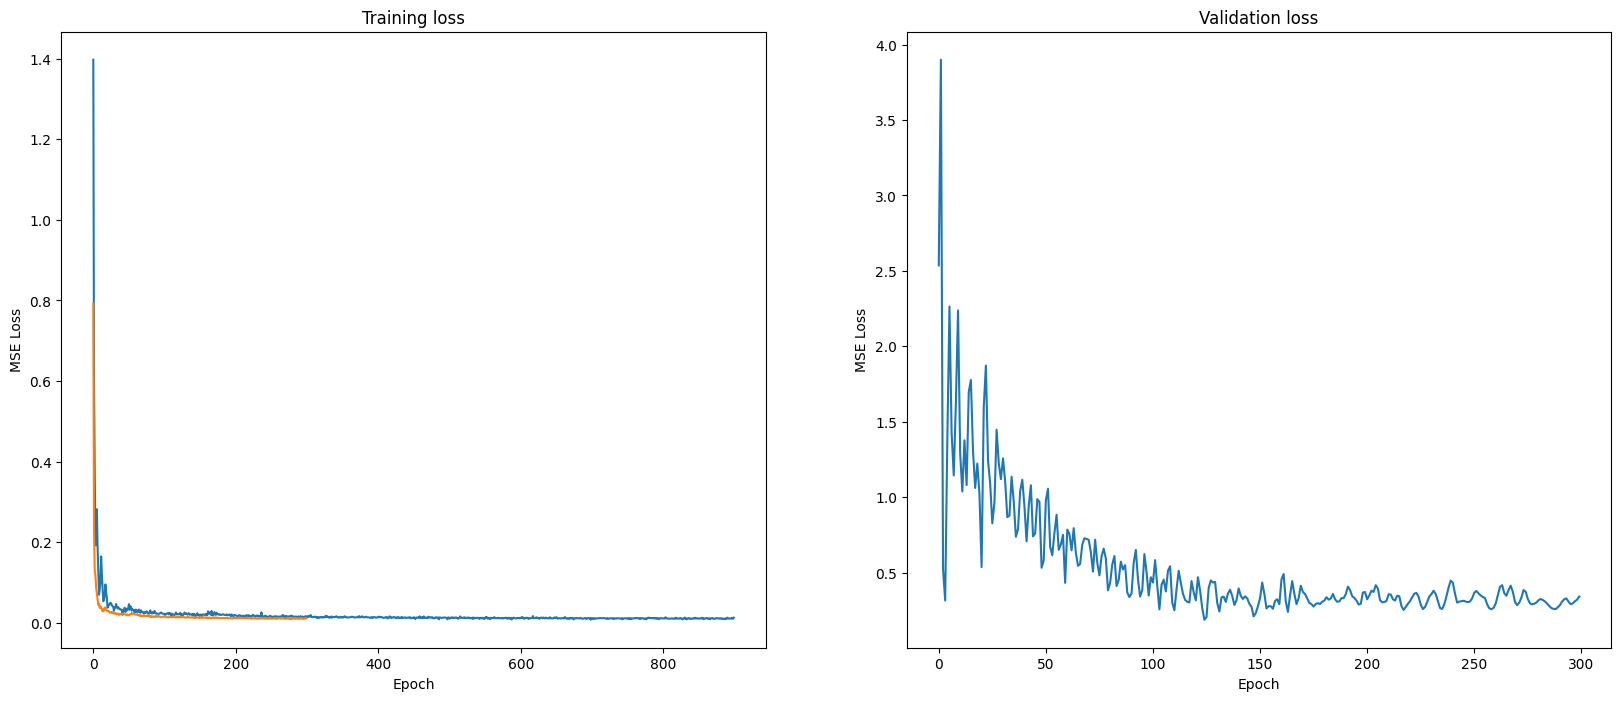

In [ ]:
optimizer.param_groups[0]['lr']=0.0001

epoch_plot=[]
val_plot=[]
num_epochs=300
for epoch in range(0, num_epochs):

    # Call train and validate 
    print("\nEpoch: {}/{}".format(epoch+1, num_epochs))
    
    curr_lr = float(optimizer.param_groups[0]['lr'])
    
    train_loss              = trainer.train()
    epoch_plot.append(train_loss)

    val_loss              = trainer.validate()
    val_plot.append(val_loss)

    # trainer.teacher_forcing_ratio=max(trainer.teacher_forcing_ratio-0.05,0.1)
    scheduler.step()

    print("\tTrain Loss {:.04f}\t Learning Rate {:.07f}\t Validation Loss {:.04f}".format(train_loss, curr_lr, val_loss))

fig, ax=plt.subplots(1,2, figsize=(20,8))
ax[0].plot(trainer.train_plot)
ax[0].plot(epoch_plot)
ax[0].set_ylabel("MSE Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_title("Training loss")

ax[1].plot(val_plot)
ax[1].set_ylabel("MSE Loss")
ax[1].set_xlabel("Epoch")
ax[1].set_title("Validation loss")


In [23]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path="/content/drive/MyDrive/stockprices/checkpoint_google_2.pth"
torch.save({'model_state_dict':trainer.model.state_dict(),
                  'optimizer_state_dict':trainer.optimizer.state_dict(),
                  'epoch': epoch}, path)

In [24]:
path="/content/drive/MyDrive/stockprices/checkpoint_google_2.pth"
checkpoint = torch.load(path)
model.load_state_dict(checkpoint['model_state_dict'])
trainer.model=model

# Testing

In [25]:
#window size: 65, context_len:5, pred_len: 5 
prediction=trainer.test(test_loader)
prediction=[i.cpu().detach().item() for i in prediction]

1178

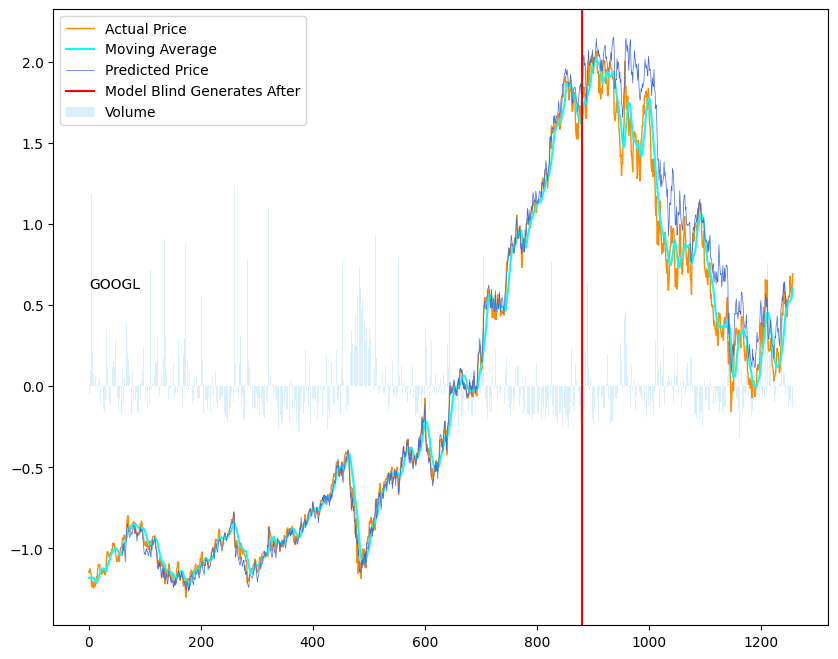

In [26]:
plt.figure(figsize=(10,8))
plt.plot(np.array(dataset)[:,4], label='Actual Price', color='darkorange', linewidth=1)
plt.plot(np.array(dataset)[:,8], label='Moving Average', color='cyan')
plt.bar(x=np.arange(0,len(dataset)), height=np.array(dataset)[:,5]/5, label='Volume', color='lightskyblue', alpha=0.3)
plt.annotate("GOOGL",xy=(0.3,0.6),textcoords='offset points')
plt.plot(np.arange(context_len,len(prediction)+context_len), prediction, label='Predicted Price',color='royalblue', linewidth=0.5)
plt.axvline(x = 880, color='r', label="Model Blind Generates After")
plt.legend()


In [ ]:
# #window size: 65, context_len:5, pred_len: 5 
# pp=[]
# pbar = tqdm(total=800,desc="predicting...")
# for i in range(800):
#   query=dataset[context_len-1+i:window_size-1+i]
#   tar=torch.FloatTensor(query).unsqueeze(0).to(device)   #1,5, 9
#   src=torch.FloatTensor(dataset[0+i: context_len+i]).unsqueeze(0).to(device)   #1, 65,9

#   out=trainer.model(src,tar) 
#   o=out.cpu().detach().numpy()[0,1]  
#   pp.append(o)
#   pbar.update()
# pbar.close()
# pp=np.squeeze(pp)
# pp.shape

In [ ]:
# #0,'Time',1,'Open',2,'High',3,'Low',4,'Close',5,'Volume',6,'change',7,'delta',8,'Moving Average'
# plt.figure(figsize=(10,8))
# plt.plot(np.array(dataset)[:1100,4], label='Actual Price', color='darkorange', linewidth=1)
# plt.plot(np.array(dataset)[:1100,8], label='Moving Average', color='cyan')
# plt.bar(x=np.arange(0,1100), height=np.array(dataset)[:1100,5]/5, label='Volume', color='lightskyblue', alpha=0.3)
# plt.annotate("GOOGL",xy=(0.3,0.6),textcoords='offset points')
# plt.plot(np.arange(context_len,800+context_len), pp, label='Predicted Price',color='royalblue', linewidth=0.5)
# plt.legend()
# # plt.ylim(200,400)

In [ ]:
import seaborn as sns

# Experiment

In [ ]:
# Login to Wandb
# Initialize your Wandb Run Here
# Save your model architecture in a txt file, and save the file to Wandb

In [ ]:
# Optional: Load your best model Checkpoint here

# TODO: Create a testing function similar to validation 
# TODO: Create a file with all predictions 
# TODO: Submit to Kaggle